# CH10: Predicting Continuous Target Variables with Regression Analysis

## Exploring the Housing dataset

In [1]:
import pandas as pd

from sklearn import datasets

In [2]:
boston = datasets.load_boston()

In [3]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df["MEDV"] = boston.target

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


## Visualizing the important characteristics of a dataset

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

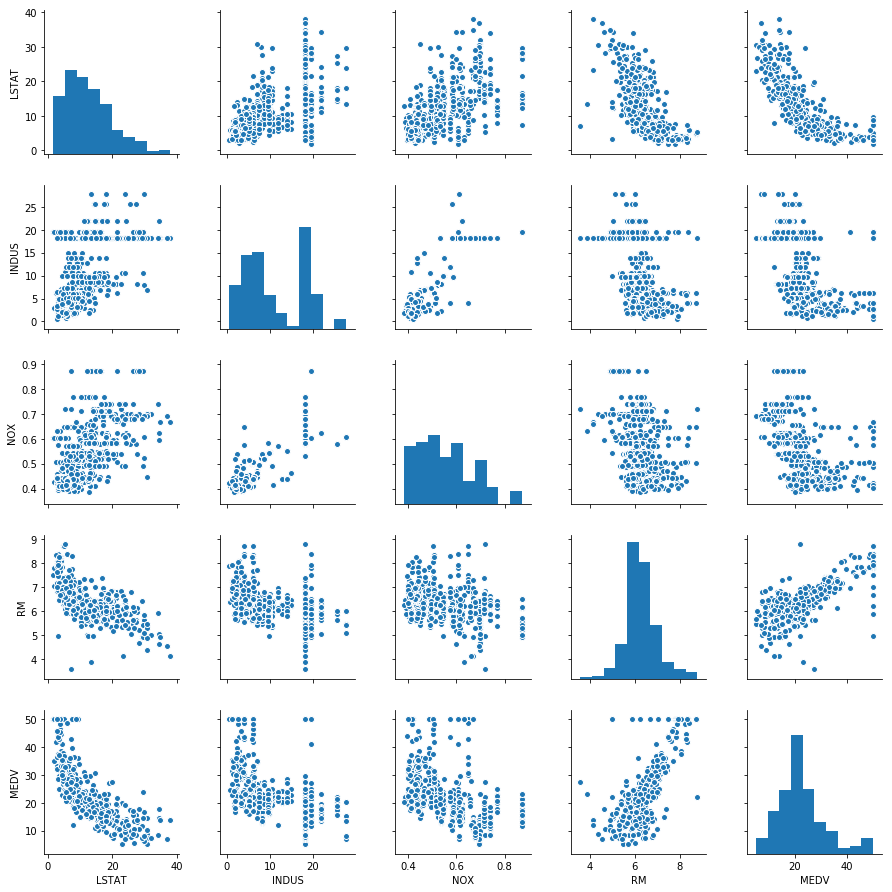

In [6]:
cols = ["LSTAT", "INDUS", "NOX", "RM", "MEDV"]

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

## Looking at relationships using a correlation matrix

In [7]:
import numpy as np

In [8]:
cm = np.corrcoef(df[cols].values.T)
cm

array([[ 1.        ,  0.60379972,  0.59087892, -0.61380827, -0.73766273],
       [ 0.60379972,  1.        ,  0.76365145, -0.39167585, -0.48372516],
       [ 0.59087892,  0.76365145,  1.        , -0.30218819, -0.42732077],
       [-0.61380827, -0.39167585, -0.30218819,  1.        ,  0.69535995],
       [-0.73766273, -0.48372516, -0.42732077,  0.69535995,  1.        ]])

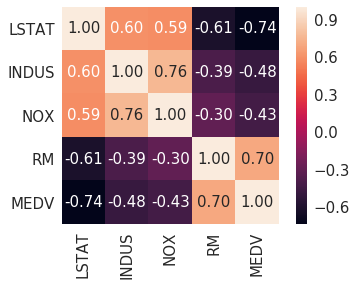

In [9]:
sns.set(font_scale=1.5)
hm = sns.heatmap(
    cm, cbar=True, annot=True, square=True, fmt="0.2f",
    annot_kws={"size": 15}, yticklabels=cols, xticklabels=cols
)
plt.show()

## Implementing an ordinary least squares linear regression model

In [10]:
class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y, method="gradient"):
        fit_method = {
            "gradient": self.fit_with_gradient, 
            "ols": self.fit_with_ols 
        }[method]
        fit_method(X, y)            
        return self
    
    def fit_with_gradient(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y-output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum()*0.5
            self.cost_.append(cost)        
    
    def fit_with_ols(self, X, y):
        Xb = np.hstack((np.ones((X.shape[0], 1)), X))
        self.w_ = np.linalg.inv(Xb.T.dot(Xb)).dot(Xb.T).dot(y)
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

In [11]:
X = df[["RM"]].values
y = df["MEDV"].values

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
sc_X = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y[:, np.newaxis])

In [14]:
X_std = sc_X.transform(X)
y_std = sc_y.transform(y[:, np.newaxis]).flatten()

In [15]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

print("slope=%.3f intercept=%.3f" % (lr.w_[0], lr.w_[1]))

slope=-0.000 intercept=0.695


In [16]:
lr_ols = LinearRegressionGD()
lr_ols.fit(X_std, y_std, method="ols")

print("slope=%.3f intercept=%.3f" % tuple(lr_ols.w_))

slope=-0.000 intercept=0.695


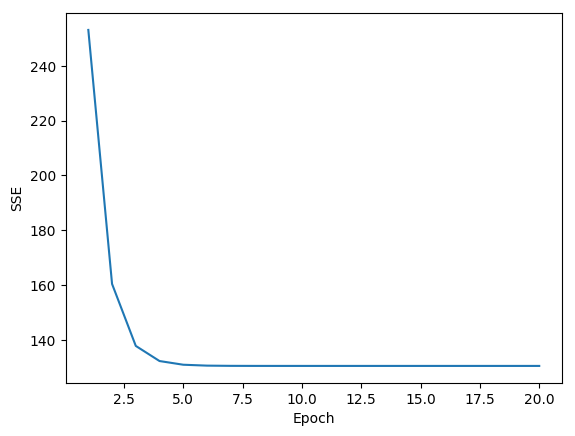

In [17]:
sns.reset_orig()
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel("SSE")
plt.xlabel("Epoch")
plt.show()

In [18]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c="steelblue", edgecolor="white", s=70)
    plt.plot(X, model.predict(X), color="black", lw=2)

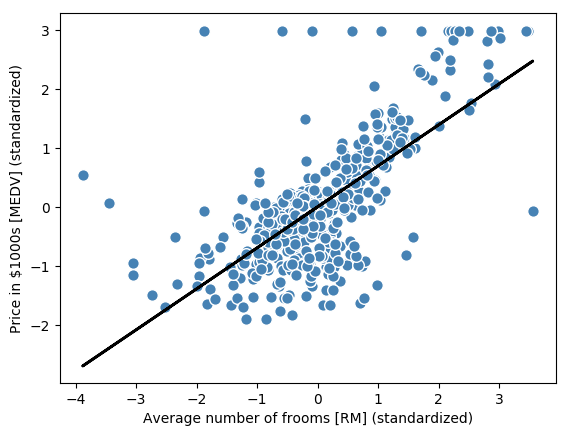

In [19]:
lin_regplot(X_std, y_std, lr)
plt.xlabel("Average number of frooms [RM] (standardized)")
plt.ylabel("Price in $1000s [MEDV] (standardized)")
plt.show()

## Estimating coefficient of a regression model with scikit-learn

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
slr = LinearRegression()
slr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

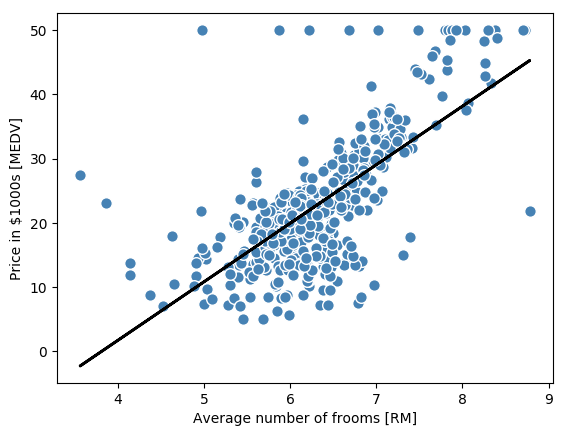

In [22]:
lin_regplot(X, y, slr)
plt.xlabel("Average number of frooms [RM]")
plt.ylabel("Price in $1000s [MEDV]")
plt.show()

## Fitting a robust regression model using RANSAC

In [23]:
from sklearn.linear_model import RANSACRegressor

In [24]:
ransac = RANSACRegressor(
    LinearRegression(), max_trials=100, min_samples=50,
    loss="absolute_loss", residual_threshold=15.0, random_state=0
)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=15.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [25]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

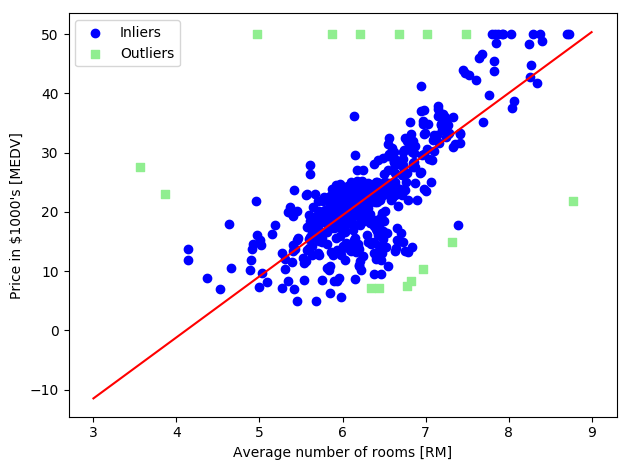

In [26]:
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(
    X[inlier_mask], y[inlier_mask],
    c="blue", marker="o", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask],
    c="lightgreen", marker="s", label="Outliers"
)
plt.plot(line_X, line_y_ransac, color="red")   
plt.xlabel("Average number of rooms [RM]")
plt.ylabel("Price in $1000\'s [MEDV]")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

## Evaluating the performance of linear regression models

In [28]:
from sklearn.model_selection import train_test_split

In [30]:
X = df.iloc[:, :-1].values
y = df["MEDV"].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
slr = LinearRegression()
slr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

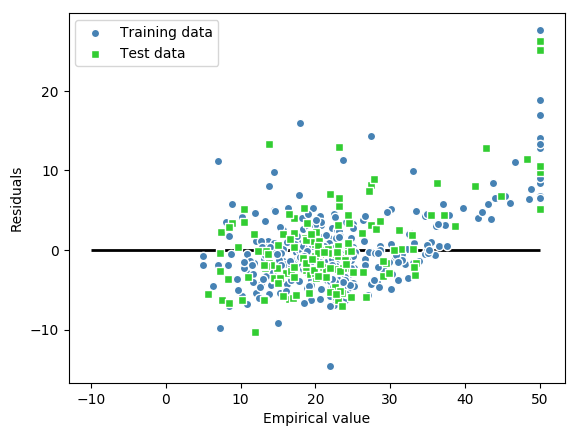

In [42]:
plt.scatter(y_train, y_train - y_train_pred, c="steelblue", marker="o", edgecolor="white", label="Training data", zorder=2)
plt.scatter(y_test, y_test - y_test_pred, c="limegreen", marker="s", edgecolor="white", label="Test data", zorder=2)
plt.xlabel("Empirical value")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2, zorder=1)
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error, r2_score

In [47]:
mean_squared_error(y_train, y_train_pred)

19.965743810157857

In [48]:
mean_squared_error(y_test, y_test_pred)

27.18384764760313

In [49]:
r2_score(y_train, y_train_pred)

0.7644563391821222

In [50]:
r2_score(y_test, y_test_pred)

0.6735280865347263

## Using regularized methods for regression

## Turning a linear regression model into a curve - polynomial regression

In [53]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [54]:
from sklearn.preprocessing import PolynomialFeatures

In [59]:
quadratic = PolynomialFeatures()
X_quad = quadratic.fit_transform(X)

In [60]:
lr = LinearRegression().fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [61]:
pr = LinearRegression().fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

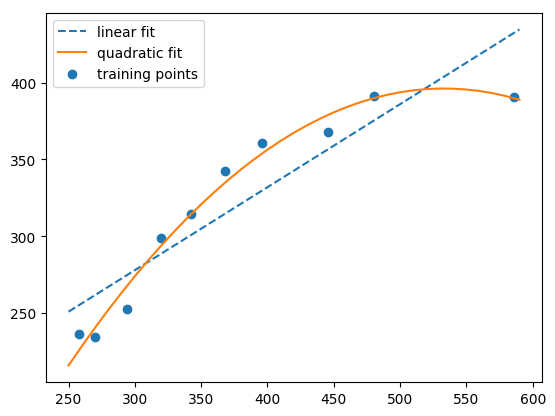

In [67]:
plt.scatter(X, y, label="training points")
plt.plot(X_fit, y_lin_fit, label="linear fit", linestyle="--")
plt.plot(X_fit, y_quad_fit, label="quadratic fit")
plt.legend(loc="upper left")
plt.show()

## Modeling nonlinear relationships in the Housing dataset

In [69]:
X = df[["LSTAT"]].values
y = df["MEDV"].values

In [70]:
regr = LinearRegression()

In [71]:
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

In [72]:
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

In [74]:
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

In [75]:
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

In [76]:
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

In [77]:
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

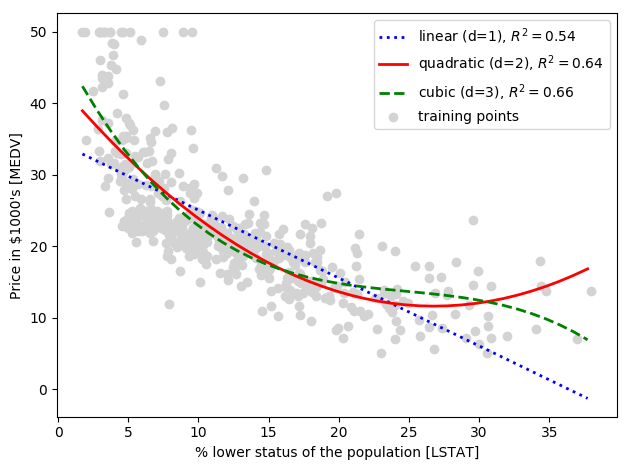

In [78]:
# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

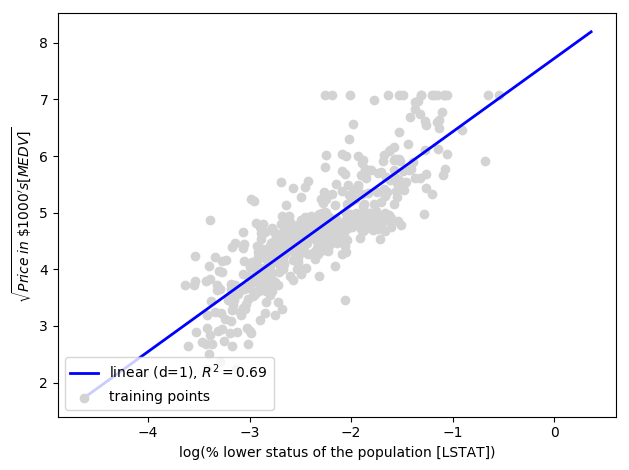

In [84]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = -np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

## Dealing with nonlinear relationships using random forests

In [86]:
from sklearn.tree import DecisionTreeRegressor

In [87]:
X = df[["LSTAT"]].values
y = df["MEDV"].values

In [88]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

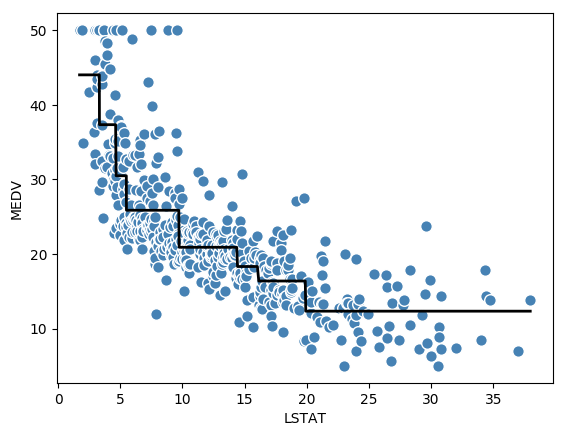

In [91]:
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("LSTAT")
plt.ylabel("MEDV")
plt.show()

## Random forest regression

In [94]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [95]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.636, test: 11.070
R^2 train: 0.980, test: 0.877


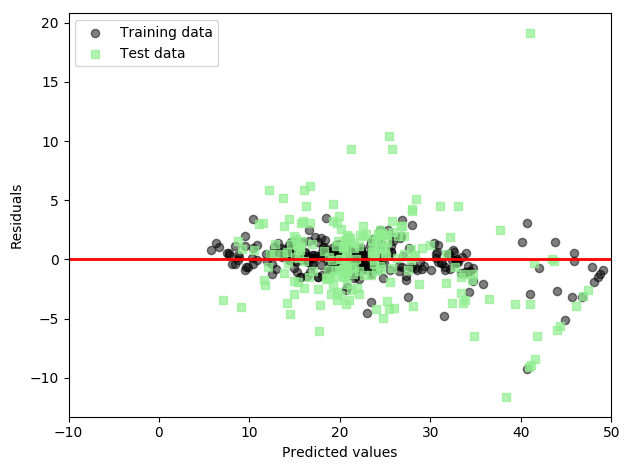

In [96]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()